# HW5: Model Predictive Control

> - Full Name: **Asemaneh Nafe**
> - Student ID: **400105285**


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/MPC.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-5-Questions/main/MPC.ipynb)

## Overview
Here the goal is to use **MPC** for [gymnasium environments](https://gymnasium.farama.org/).
More specificly we focus on the [Pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/) environment and try to solve it using [mpc.pytorch](https://locuslab.github.io/mpc.pytorch/).




In [1]:
# @title Imports

# Stuff you (might) need
import random
import numpy as np
import gymnasium as gym

import torch
from torch import nn
import torch.autograd
from tqdm.notebook import trange
import math

# Stuff used for visualization
from matplotlib import pyplot as plt
from gymnasium.wrappers import RecordVideo
import base64
import imageio
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

In [2]:
# @title Visualization Functions

def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return HTML(tag)


def plot_results(rewards, actions):
    plt.plot(rewards, label='Rewards')
    plt.plot(actions, label='Actions')
    plt.legend()
    plt.title(f"Total reward: {sum(rewards):.2f}")
    plt.show()

# Explore the Environment (25 points)

To better understand the environment, let's first see what a random agent does.

In [4]:
# Initialize the pendulum environment with video recording enabled
env = gym.make('Pendulum-v1', render_mode='rgb_array')

# Create a directory to save the video
video_directory = "random_videos"
env = RecordVideo(env, video_directory)

# Set the number of steps to record
num_steps = 500

# TODO: Reset the environment to get the initial state
state, _ = env.reset()

for _ in (pbar := trange(num_steps)):
    # Sample a random action
    action = env.action_space.sample()

    # Step the environment
    next_state, reward, done, truncated, _ = env.step(action)

    # Render the environment
    env.render()

    # If done, reset and get new state
    if done or truncated:
        state, _ = env.reset()
    else:
        state = next_state


    pbar.set_description(f'Action = {action[0]:.2f} | Reward = {reward:.2f}')

# Close the environment to finalize the video
env.close()

# Show the video
embed_mp4(f'{video_directory}/rl-video-episode-0.mp4')

  0%|          | 0/500 [00:00<?, ?it/s]

The goal of the [Pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/) environment in [Gymnasium](https://gymnasium.farama.org/) is to swing a pendulum to an upright position and keep it balanced there.
In this environment, you control a torque that can be applied to the pendulum.
The objective is to apply the right amount of torque to swing the pendulum up and maintain its upright position.

## Simulation Tools

Both the `angle_normalize` function and the `PendulumDynamics` class are fundamental components for accurately simulating, analyzing, and controlling the pendulum system.
They ensure consistency in angle representation and provide a realistic model of the pendulum's behavior, enabling effective control strategies.

We use the `angle_normalize` function for:

*   **Consistency**: When dealing with angles, it's important to keep them within a standard range to ensure consistency in calculations.
*   **Handling Wrapping**: Angles can wrap around when they exceed $2\pi$ or drop below $-2\pi$. Normalizing angles helps avoid confusion and errors that can arise from angle wrapping.


And we use the `PendulumDynamics` class for:

*   **Modeling Physical Behavior**: The `PendulumDynamics` class models the physical behavior of the pendulum.
*   **Simulation and Control**: This class allows us to simulate the pendulum's response to different actions, which is crucial for designing and testing control algorithms.
*   **Optimization**: Understanding the dynamics of the pendulum helps in optimizing the control inputs. The class encapsulates the physics involved, enabling us to apply control techniques like Model Predictive Control (MPC) to achieve the desired behavior.




In [5]:
class PendulumDynamics(nn.Module):
    def forward(self, state, action):
        th = state[:, 0].view(-1, 1)
        thdot = state[:, 1].view(-1, 1)

        g = 10 # default value of the environment (not 9.81)
        m = 1
        l = 1
        dt = 0.05

        u = action
        u = torch.clamp(u, -2, 2)

        newthdot = thdot + (-3 * g / (2 * l) * torch.sin(th + np.pi) + 3. / (m * l ** 2) * u) * dt
        newth = th + newthdot * dt
        newthdot = torch.clamp(newthdot, -8, 8)

        state = torch.cat((angle_normalize(newth), newthdot), dim=1)
        return state


def angle_normalize(x):
    return (((x + math.pi) % (2 * math.pi)) - math.pi)

# Model Predictive Control (50 points)

[mpc.pytorch](https://locuslab.github.io/mpc.pytorch/) is a library that provides a fast and differentiable [Model Predictive Control](https://en.wikipedia.org/wiki/Model_predictive_control) (MPC) solver for PyTorch. It was developed by researchers at [LocusLab](https://locuslab.github.io/) and is designed to integrate seamlessly with PyTorch, allowing for efficient and flexible control of dynamic systems.

If you are interested to learn more, check out [OptNet](https://arxiv.org/abs/1703.00443) and [Differentiable MPC](https://arxiv.org/abs/1810.13400).

## Quick Setup

In order to install this library you can use `pip`:

In [6]:
! pip install mpc

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.8 MB/s eta 0:00:00
  Cr

While `mpc` offers a lot, in this notebook we are going to focus only on the core features.
To learn more checkout the [GitHub repository](https://github.com/locuslab/mpc.pytorch) of this project.

In [7]:
from mpc import mpc

## The Cost Function

The `define_swingup_goal` function creates a cost function that the MPC algorithm uses to determine the optimal control actions to achieve the desired pendulum swing-up task.
It considers both the desired state (upright and stationary) and penalizes large control inputs to ensure smooth control actions.

In [8]:
def define_swingup_goal():
    goal_weights = torch.tensor((1., 0.1))  # Weights for theta and theta_dot
    goal_state = torch.tensor((0., 0.))  # Desired state (theta=0, theta_dot=0)
    ctrl_penalty = 0.001
    q = torch.cat((goal_weights, ctrl_penalty * torch.ones(1)))  # Combined weights
    px = -torch.sqrt(goal_weights) * goal_state
    p = torch.cat((px, torch.zeros(1)))
    Q = torch.diag(q).repeat(TIMESTEPS, N_BATCH, 1, 1)  # Cost matrix
    p = p.repeat(TIMESTEPS, N_BATCH, 1)
    return mpc.QuadCost(Q, p) # Quadratic cost

## Running MPC

To run the MPC, in each iteration:

1.   First you obtain the current state of the environment and convert it to a tensor.
2.   Then you recreate the MPC controller using the updated `u_init` and calculate the optimal control actions based on the current state, dynamics, and cost function.
3.   Next you take the first planned action and update `u_init` with the remaining actions.
4.   Finally you take a step in the environment and store the rewards and actions.

Remember that `u_init` serves as the initial guess for the control inputs.

  0%|          | 0/800 [00:00<?, ?it/s]

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.


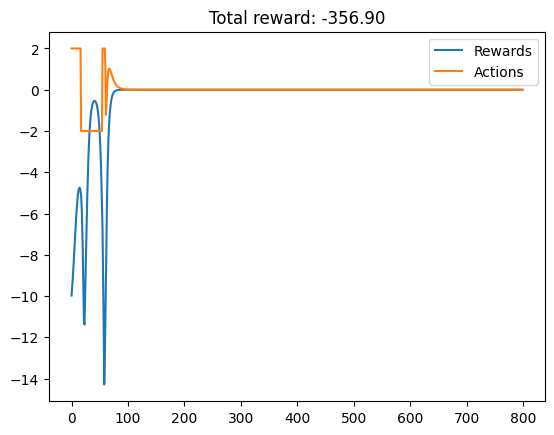

In [27]:
# Select the hyperparameters
RUN_ITER = 800   # Number of iterations to run MPC
TIMESTEPS = 15   # Number of time steps in MPC horizon
N_BATCH = 1      # Number of trajectories to optimize at each step
LQR_ITER = 5     # Number of LQR iterations for optimization


# Setup the environmnet
env = gym.make('Pendulum-v1', render_mode='rgb_array')
video_directory = "mpc_videoss"
env = RecordVideo(env, video_directory)
env.reset()  # Reset the underlying environment
env.unwrapped.state = [np.pi, 1] # Environment must start in downward position


# Define the cost function and initialize u
cost = define_swingup_goal()
u_init = None


# Run MPC
rewards, actions = [], []
for _ in (pbar := trange(RUN_ITER)):
    state = env.unwrapped.state.copy()
    state = torch.tensor(state, dtype=torch.float32).view(1, -1)
    # recreate controller using updated u_init (kind of wasteful right?)
    ctrl = mpc.MPC(2, 1, TIMESTEPS, u_lower=-2.0, u_upper=+2.0,
                   lqr_iter=LQR_ITER, exit_unconverged=False, eps=1e-2,
                   n_batch=N_BATCH, backprop=False, verbose=0, u_init=u_init,
                   grad_method=mpc.GradMethods.AUTO_DIFF)

    # compute action based on current state, dynamics, and cost
    nominal_states, nominal_actions, nominal_objs = ctrl(state, cost, PendulumDynamics())

    # TODO: Take first planned action
    action =  nominal_actions[0].detach().numpy()

   # Update u_init
    u_init = torch.cat((nominal_actions[1:], torch.zeros(1, N_BATCH, 1)), dim=0)

    # TODO: Take a step in the environment
    next_state, reward, done, _, _ = env.step(action)

    # TODO: Store the latest action and reward
    actions.append(action[0])
    rewards.append(reward)

    pbar.set_description(f"Action = {actions[-1][0]:.2f} | Reward = {rewards[-1][0]:.2f}")

    env.render()

env.close()

reward_values = [reward.item() for reward in rewards]
# Plot the results
plot_results(reward_values, actions)

In [28]:
# Show the policy learned
embed_mp4(f'{video_directory}/rl-video-episode-0.mp4')

# Questions (25 points)

Based on your experiments, answer the following questions:



*   How does the number of LQR iterations affect the MPC?
*   What if we didn't have access to the model dynamics? Could we still use MPC?
*   Do `TIMESTEPS` or `N_BATCH` matter here? Explain.
*   Why do you think we chose to set the initial state of the environment to the downward position?
*   As time progresses (later iterations) what happens to the actions and rewards? Why?

`Your Answers:`


#1
The more iterations the LQR algorithm performs, the more accurate the solution will be. In the context of MPC, where you are constantly re-optimizing the control inputs based on updated system states, a higher number of iterations could help improve the precision of the control inputs.

However, there's a trade-off: increasing the number of iterations can result in better accuracy but also takes more time to compute. So, if you have many iterations, the optimization might take longer to solve, potentially slowing down the control process.

MPC requires solving an optimization problem at each time step, and if you're using LQR as the solver, the number of iterations required to reach the optimal solution can impact how fast the controller can react. More iterations typically mean more computational time, and this could be a problem in systems that need real-time responses or have limited computational resources.

If you're running multiple iterations to achieve a highly accurate solution, there may not be enough time to update the control signal before the next iteration.

Fewer LQR iterations can make the optimization process faster, which is useful when the system needs to make quick decisions. However, it might lead to less accurate solutions, potentially making the MPC less effective at controlling the system in a highly optimized way.

On the other hand, more iterations can produce more robust and refined control signals, leading to better long-term performance. But this also means the system might react slower, which could be undesirable for highly dynamic systems.

as you can see in the bellow code by decresing the number of itteration the pendluem the number of pisode to find the optimal policy and reaching the zero reward increases and it converges to zero later.

  0%|          | 0/100 [00:00<?, ?it/s]

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not conver

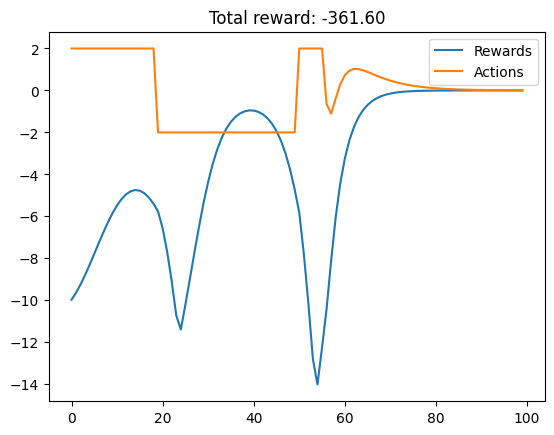

In [52]:
# Select the hyperparameters
RUN_ITER = 100   # Number of iterations to run MPC
TIMESTEPS = 15   # Number of time steps in MPC horizon
N_BATCH = 1      # Number of trajectories to optimize at each step
LQR_ITER = 1     # Number of LQR iterations for optimization


# Setup the environmnet
env = gym.make('Pendulum-v1', render_mode='rgb_array')
video_directory = "mpc_videoss"
env = RecordVideo(env, video_directory)
env.reset()  # Reset the underlying environment
env.unwrapped.state = [np.pi, 1] # Environment must start in downward position


# Define the cost function and initialize u
cost = define_swingup_goal()
u_init = None


# Run MPC
rewards, actions = [], []
for _ in (pbar := trange(RUN_ITER)):
    state = env.unwrapped.state.copy()
    state = torch.tensor(state, dtype=torch.float32).view(1, -1).repeat(N_BATCH, 1)

    # recreate controller using updated u_init (kind of wasteful right?)
    ctrl = mpc.MPC(2, 1, TIMESTEPS, u_lower=-2.0, u_upper=+2.0,
                   lqr_iter=LQR_ITER, exit_unconverged=False, eps=1e-2,
                   n_batch=N_BATCH, backprop=False, verbose=0, u_init=u_init,
                   grad_method=mpc.GradMethods.AUTO_DIFF)

    # compute action based on current state, dynamics, and cost
    nominal_states, nominal_actions, nominal_objs = ctrl(state, cost, PendulumDynamics())

    # TODO: Take first planned action
    action =  nominal_actions[0].detach().numpy()

   # Update u_init
    u_init = torch.cat((nominal_actions[1:], torch.zeros(1, N_BATCH, 1)), dim=0)

    # TODO: Take a step in the environment
    next_state, reward, done, _, _ = env.step(action)

    # TODO: Store the latest action and reward
    actions.append(action[0])
    rewards.append(reward)

    pbar.set_description(f"Action = {actions[-1][0]:.2f} | Reward = {rewards[-1][0]:.2f}")

    env.render()

env.close()

reward_values = [reward.item() for reward in rewards]
# Plot the results
plot_results(reward_values, actions)
embed_mp4(f'{video_directory}/rl-video-episode-0.mp4')

#2
If we didn't have access to the model dynamics, traditional Model Predictive Control (MPC) would face challenges because it typically relies on a mathematical model of the system's behavior to predict future states and optimize control inputs. However, there are still ways to use MPC without direct access to the model:

Data-driven MPC:

In this approach, we use historical data or real-time measurements to approximate the system's dynamics. Techniques like system identification can be applied to learn the model from the data over time. This learned model can then be used in an MPC framework to make predictions and control decisions.

Learning-based MPC:

You can use machine learning models (like neural networks) to learn the dynamics of the system. These models, once trained, can approximate the system's behavior and serve as a substitute for traditional physical models in the MPC optimization process.

Nonlinear MPC (NMPC):

If the system is nonlinear and we lack an exact model, NMPC can still be applied with an approximate model or even a learned surrogate model. In this case, the optimization would still proceed, but it might be based on simpler approximations or black-box models that don't directly reflect the exact dynamics.

Reinforcement Learning (RL):

RL-based control methods, which share similarities with MPC, can be used to control systems without requiring explicit dynamics. Here, an agent learns the control policy by interacting with the environment, learning from the outcomes rather than using a fixed model.

#3
Yes, both TIMESTEPS and N_BATCH can have an impact on how MPC performs, especially in the context of learning-based or data-driven MPC approaches.

TIMESTEPS:

TIMESTEPS refer to how far ahead the controller looks in the future to predict and optimize the system's behavior. A larger number of timesteps means that the controller considers a longer horizon when making decisions. This can improve the performance, especially in systems with long-term dynamics, but it also increases the computational load.

If the timesteps are too large, the predictions may become less accurate, especially if the system dynamics are uncertain or not fully understood. On the other hand, too few timesteps might lead to short-sighted decisions that don't account for the broader context of the system. as you can see in bellow code both very short and long time steps wiill lead to bad learning.

N_BATCH:

N_BATCH refers to the number of parallel computations or simulations performed during the optimization process. In the context of data-driven MPC or machine learning models, having a larger batch size can help the model generalize better by using more data points to make decisions. However, larger batches require more memory and computational resources.

In reinforcement learning, for example, a larger batch size might help the model learn faster, but it can also lead to slower convergence or overfitting if not tuned properly. Smaller batch sizes, while requiring less memory, might result in less stable training or slower learning.

  0%|          | 0/100 [00:00<?, ?it/s]

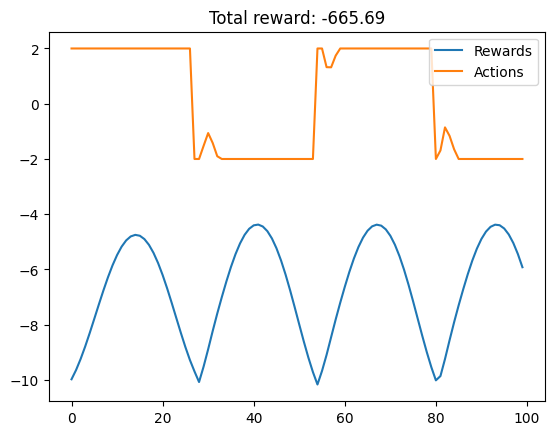

In [33]:
RUN_ITER = 100   # Number of iterations to run MPC
TIMESTEPS = 3   # Number of time steps in MPC horizon
N_BATCH = 1      # Number of trajectories to optimize at each step
LQR_ITER = 5     # Number of LQR iterations for optimization


# Setup the environmnet
env = gym.make('Pendulum-v1', render_mode='rgb_array')
video_directory = "mpc_videoss"
env = RecordVideo(env, video_directory)
env.reset()  # Reset the underlying environment
env.unwrapped.state = [np.pi, 1] # Environment must start in downward position


# Define the cost function and initialize u
cost = define_swingup_goal()
u_init = None


# Run MPC
rewards, actions = [], []
for _ in (pbar := trange(RUN_ITER)):
    state = env.unwrapped.state.copy()
    state = torch.tensor(state, dtype=torch.float32).view(1, -1)
    # recreate controller using updated u_init (kind of wasteful right?)
    ctrl = mpc.MPC(2, 1, TIMESTEPS, u_lower=-2.0, u_upper=+2.0,
                   lqr_iter=LQR_ITER, exit_unconverged=False, eps=1e-2,
                   n_batch=N_BATCH, backprop=False, verbose=0, u_init=u_init,
                   grad_method=mpc.GradMethods.AUTO_DIFF)

    # compute action based on current state, dynamics, and cost
    nominal_states, nominal_actions, nominal_objs = ctrl(state, cost, PendulumDynamics())

    # TODO: Take first planned action
    action =  nominal_actions[0].detach().numpy()

   # Update u_init
    u_init = torch.cat((nominal_actions[1:], torch.zeros(1, N_BATCH, 1)), dim=0)

    # TODO: Take a step in the environment
    next_state, reward, done, _, _ = env.step(action)

    # TODO: Store the latest action and reward
    actions.append(action[0])
    rewards.append(reward)

    pbar.set_description(f"Action = {actions[-1][0]:.2f} | Reward = {rewards[-1][0]:.2f}")

    env.render()

env.close()

reward_values = [reward.item() for reward in rewards]
# Plot the results
plot_results(reward_values, actions)
embed_mp4(f'{video_directory}/rl-video-episode-0.mp4')

  0%|          | 0/100 [00:00<?, ?it/s]

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.

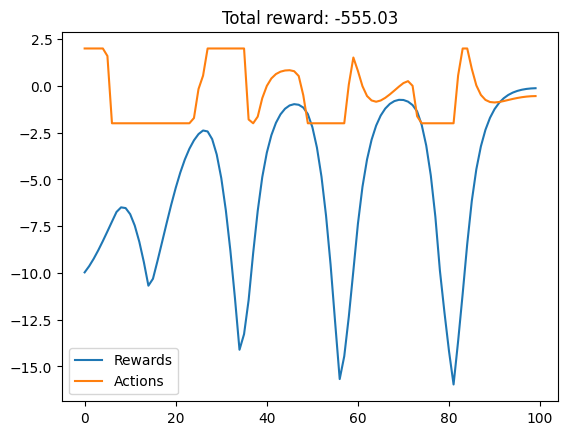

In [41]:
# Select the hyperparameters
RUN_ITER = 100   # Number of iterations to run MPC
TIMESTEPS = 300  # Number of time steps in MPC horizon
N_BATCH = 1      # Number of trajectories to optimize at each step
LQR_ITER = 5     # Number of LQR iterations for optimization


# Setup the environmnet
env = gym.make('Pendulum-v1', render_mode='rgb_array')
video_directory = "mpc_videoss"
env = RecordVideo(env, video_directory)
env.reset()  # Reset the underlying environment
env.unwrapped.state = [np.pi, 1] # Environment must start in downward position


# Define the cost function and initialize u
cost = define_swingup_goal()
u_init = None


# Run MPC
rewards, actions = [], []
for _ in (pbar := trange(RUN_ITER)):
    state = env.unwrapped.state.copy()
    state = torch.tensor(state, dtype=torch.float32).view(1, -1)
    # recreate controller using updated u_init (kind of wasteful right?)
    ctrl = mpc.MPC(2, 1, TIMESTEPS, u_lower=-2.0, u_upper=+2.0,
                   lqr_iter=LQR_ITER, exit_unconverged=False, eps=1e-2,
                   n_batch=N_BATCH, backprop=False, verbose=0, u_init=u_init,
                   grad_method=mpc.GradMethods.AUTO_DIFF)

    # compute action based on current state, dynamics, and cost
    nominal_states, nominal_actions, nominal_objs = ctrl(state, cost, PendulumDynamics())

    # TODO: Take first planned action
    action =  nominal_actions[0].detach().numpy()

   # Update u_init
    u_init = torch.cat((nominal_actions[1:], torch.zeros(1, N_BATCH, 1)), dim=0)

    # TODO: Take a step in the environment
    next_state, reward, done, _, _ = env.step(action)

    # TODO: Store the latest action and reward
    actions.append(action[0])
    rewards.append(reward)

    pbar.set_description(f"Action = {actions[-1][0]:.2f} | Reward = {rewards[-1][0]:.2f}")

    env.render()

env.close()

reward_values = [reward.item() for reward in rewards]
# Plot the results
plot_results(reward_values, actions)
embed_mp4(f'{video_directory}/rl-video-episode-0.mp4')

#4
Stability: The downward position is typically an unstable equilibrium point. By starting the system there, we test how well the controller or algorithm can stabilize the system. If it can recover from the downward position, it’s likely to be able to handle other scenarios with less instability.

Challenge for the Controller: The downward position provides a "worst-case" starting point, meaning that the controller has to work harder to bring the system into a stable state (like the upright position). This is a good way to test the robustness and effectiveness of the control strategy, especially in systems that involve balancing or stabilization.

Learning and Performance: For learning algorithms, like reinforcement learning or model predictive control (MPC), starting from an unstable position forces the algorithm to explore more of the state space. This encourages the algorithm to learn how to perform well under challenging conditions, improving its generalizability.

Physical Relevance: In many real-world applications, the system may naturally be in the downward position, especially when starting from a resting state. For example, a pendulum left to hang will start in the downward position, making it a natural choice for many experiments or simulations.

#5
As time progresses in later iterations, the actions and rewards typically show a pattern of improvement due to the learning and adaptation of the system, especially in reinforcement learning or model-based control like MPC.

Actions: Early on, the actions might be more exploratory or random, especially if the model hasn’t learned the dynamics well. Over time, as the system collects more data, the actions become more refined and optimal. The model begins to make decisions that are more targeted at achieving the desired outcome, such as balancing the pendulum upright or stabilizing the system. So, the actions should converge to a more efficient policy as the model learns.

Rewards: Initially, rewards might be low because the system is far from the optimal state and may make inefficient decisions. However, as the system learns and adapts to its environment, it should start taking actions that bring it closer to the goal (e.g., balancing a pendulum), resulting in higher rewards. The rewards are a reflection of how well the system is performing based on its actions, so as time progresses, we generally see the rewards increase.

This improvement is due to better control policies being learned, where the system increasingly takes actions that bring it closer to the desired goal, which in turn results in higher rewards.
The periodic behavior in the reward at the beginning is likely due to the pendulum oscillating back and forth before stabilizing. Here’s why:

Initial Exploration & High Energy Swings

At the start, the controller applies forces to swing the pendulum up, causing oscillatory motion.

These swings lead to fluctuating rewards because the reward function is based on how well the pendulum aligns with the upright position and minimizes control effort.

Underactuated System Dynamics

The pendulum initially lacks enough control authority to reach the goal smoothly.

It follows a natural oscillation pattern as the MPC refines the control actions over time.

MPC Adjusting Actions

Since Model Predictive Control (MPC) optimizes actions over a horizon, the controller starts with suboptimal moves, causing oscillations.

As iterations progress, MPC learns better actions, and the oscillations dampen, leading to more stable rewards.